### Load dataset

In [28]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_talents():
    # Load csv dataset
    potential_talents_filepath = '../data/raw/potential-talents.xlsx'
    potential_talents = pd.read_excel(potential_talents_filepath)
    return potential_talents
potential_talents = load_talents()

In [24]:
potential_talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### Explore and transform dataset

In [14]:
potential_talents.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [29]:
# Remove the fit column
potential_talents.drop('fit',axis=1, inplace=True)

In [30]:
pre_potential_talents = potential_talents.drop_duplicates(subset=['job_title', 'location', 'connection'])

In [31]:
pre_potential_talents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53 non-null     int64 
 1   job_title   53 non-null     object
 2   location    53 non-null     object
 3   connection  53 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [3]:
# See unique values in the job_title feature
potential_talents.job_title.value_counts()

job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, C

### Preprocessing

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_candidate(row):
    # preserve id feature
    candidate_id = row['id']

    # Job Title Preprocessing
    title = row['job_title']
    # convert all characters to lowercase in order to standardize the text
    # Convert all characters to lowercase to standardize text
    text = title.lower()
    
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)
    
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Abbreviation expansion
    abbreviation_map = {
        "dev": "developer",
        'chro': 'chief human resources officer',
        'svp': 'senior vice president',
        'gphr': 'global professional in human resources',
        'hris': 'human resources management system',
        'csr': 'corporate social responsibility',
        'sphr': 'strategic and policy-making certification',
        'hr': 'human resources',
        "mgr": "manager",
        "sr": "senior",
        "jr": "junior",
        "eng": "engineer",
        "asst": "assistant",
        "assoc": "associate",
        "admin": "administrator",
        "qa": "quality",
        "vp": "vicepresident",
    }
    # Replace words using abbreviation map dictionary 
    new_tokens = []
    for word in tokens:
        if word in abbreviation_map:
            new_tokens.append(abbreviation_map[word])
        else:
            new_tokens.append(word)

    tokens = new_tokens
    # After all cleaning steps, rejoin tokens into single string
    job_title_cleaned =  ' '.join(tokens)

    # Location Preprocessing 
    location = row['location'].lower().strip()
    location = re.sub(r'[^\w\s]', '', location)
    location = location.replace("türkiye", "turkey").replace("kanada", "canada")
    location = location.replace("amerika birleşik devletleri", "united states america")

    # Connection Preprocessing
    connection = row['connection']
    if isinstance(connection, str) and '500+' in connection:
        connection = 600
    else:
        try:
            connection = int(connection)
        except (ValueError, TypeError):
            connection = None 
    
    return {
        'id': candidate_id,
        'job_title': job_title_cleaned,
        'location': location,
        'connection': connection
    }

processed_potential_talents = potential_talents.apply(preprocess_candidate, axis=1, result_type='expand').drop_duplicates(subset=['job_title', 'location', 'connection'])
processed_potential_talents.to_csv('../data/interim/processed_potential_talents.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [63]:
processed_potential_talents = pd.read_csv('../data/interim/processed_potential_talents.csv')

In [6]:
processed_potential_talents.value_counts()

id   job_title                                                                                                                                                                                                                           location                            connection
1    ct bauer college business graduate magna cum laude aspiring human resource professional                                                                                                                                             houston texas                       85            1
79   liberal art major aspiring human resource analyst                                                                                                                                                                                   baton rouge louisiana area          7             1
81   senior human resource business partner heil environmental                                                                                        

In [6]:
from collections import Counter

job_titles = processed_potential_talents['job_title']

# initialize Counter
word_counts = Counter()

# Count words
for title in job_titles.dropna():
    for word in title.split():
        word_counts[word] += 1
# Print summary and top words
print('There are', len(word_counts), 'unique words in the job title column\n')

print("Top 20 Most Common Words in Job Titles:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")


There are 182 unique words in the job title column

Top 20 Most Common Words in Job Titles:
human: 39
resource: 34
aspiring: 13
professional: 11
seeking: 10
manager: 7
university: 6
student: 6
management: 6
business: 5
generalist: 5
resources: 5
specialist: 4
position: 4
senior: 3
system: 3
opportunity: 3
director: 3
major: 3
college: 2


From this we see that most common words in this job application list are 'human', 'resource', 'aspiring', 'professional', 'resources', 'student', 'seeking'.  

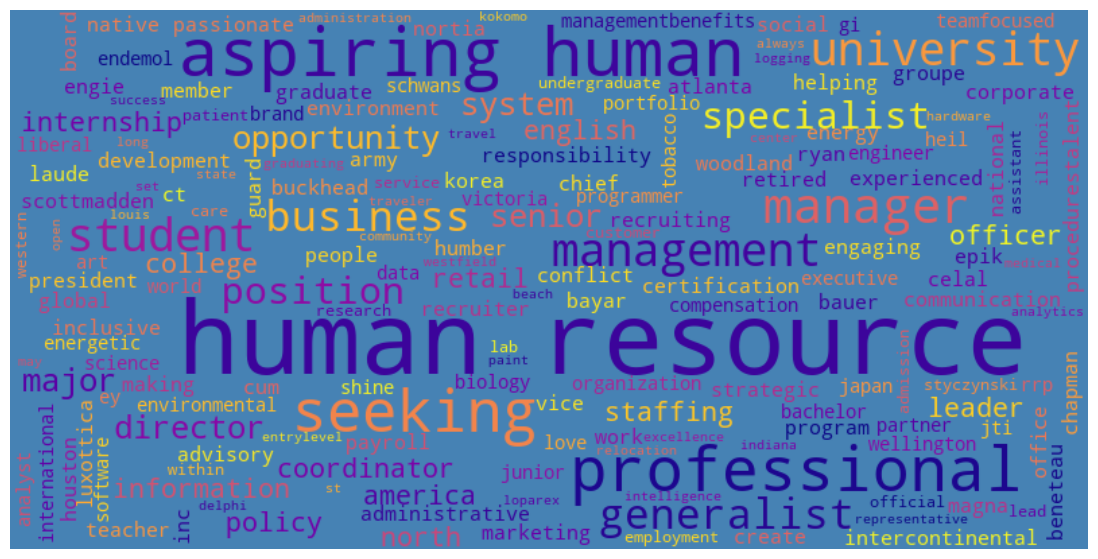

In [7]:
# Function to generate a word cloud from 'job_title' 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(job_titles):
    # combine all job titles into a single string
    text = ' '.join(job_titles.dropna())

    # generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='steelblue',
        colormap='plasma',
        max_words=200,
        random_state=42
    ).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #plt.title('Job Title Word Cloud', fontsize=20)
    plt.show()

job_titles = processed_potential_talents['job_title']
plot_word_cloud(job_titles)

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_user_keywords(job_title, location):
    # Job title preprocessing
    text = job_title.lower()    # Convert to lowercase
    text = re.sub(r'\d+', '', text)     # remove digits 
    text = text.translate(str.maketrans('','',string.punctuation))   # remove punctuation
    # split the string into tokens
    tokens = nltk.word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Abbreviation expansion
    abbreviation_map = {
        "dev": "developer",
        'chro': 'chief human resources officer',
        'svp': 'senior vice president',
        'gphr': 'global professional in human resources',
        'hris': 'human resources management system',
        'csr': 'corporate social responsibility',
        'sphr': 'strategic and policy-making certification',
        'hr': 'human resources',
        "mgr": "manager",
        "sr": "senior",
        "jr": "junior",
        "eng": "engineer",
        "asst": "assistant",
        "assoc": "associate",
        "admin": "administrator",
        "qa": "quality",
        "vp": "vicepresident",
    }
    # Replace words using abbreviation map dictionary 
    new_tokens = []
    for word in tokens:
        if word in abbreviation_map:
            new_tokens.append(abbreviation_map[word])
        else:
            new_tokens.append(word)

    tokens = new_tokens
    # After all cleaning steps, rejoin tokens into single string
    job_title_cleaned =  ' '.join(tokens)

    # Location Preprocessing 
    location_cleaned = location.lower().strip()
    location_cleaned = re.sub(r'[^\w\s]', '', location_cleaned)

    # Combine processed job_title and location into one string for vectorization
    combined_text = f"{job_title_cleaned} {location_cleaned}"
    
    return combined_text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aduro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Global User Entered KeyWords

In [9]:
# User enters keywords
# Add more query words
user_job_title = "Aspiring Human Resources"
user_location = "North Carolina Area"
keyword = preprocess_user_keywords(user_job_title, user_location)
keyword_bert = f"{user_job_title} {user_location}".strip()
print(keyword)

aspiring human resource north carolina area


### Bag of Words
Method for converting text into numerical features that machine learnig models can understand. The key idea behind BoW is:
* It represents text data by counting the occurrence of each word in the text, disregarding grammar and word order but keeping track of word frequency.
* It creates a vocabulary of all unique words appearing in the dataset.
* Each text sample (in this project, a candidate’s job title or location) is represented as a vector whose length equals the size of this vocabulary.
* Each position in the vector shows how many times the corresponding word appears in the text sample.  
  
Why Use Bag of Words in This Project?  
In this project, we are predicting candidate fit based on features like job_title and location. Since these fields are text, machine learning models cannot directly use them unless they are transformed into numbers.

Bag of Words provides a simple, interpretable way to:

1. Quantify job title similarities: Candidates with job titles containing similar words will have similar vectors.

2. Capture important keywords: Words like “HR”, “Manager”, “Engineer”, or “Coordinator” directly affect a candidate’s potential fit for a role.

3. Enable similarity calculations: Once job titles are represented as vectors, you can compute cosine similarity between:

   * Candidate’s job title and the search keyword.

   * Candidate’s job title and the starred candidates’ job titles.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rank_candidates_BoW(keyword, df):
    """ 
    Uses Bag of Words vectorization (BoW - CountVectorizer)
    Combine job_title and location per candidate into a single string
    Compute cosine similarity between candidates and a user provided keyword string
    Rank candidates by fit score and break ties by higher connection counts 
    Also returns the keyword vector for visualization
    """
    # Combine job_title and location into one feature for each candidate
    df = df.copy()
    df['text'] = df['job_title'] + ' ' + df['location']
    title_location = df['text'].astype(str).tolist()

    # Append user keyword to collection, to allow computing similarity between candidates and user query
    title_location.append(keyword)

    # Initialize CountVectorizer (BoW)
    vectorizer = CountVectorizer(max_features=300)
    vectors = vectorizer.fit_transform(title_location)

    # Extract BoW embeddings
    df['embedding'] = list(vectors[:-1].toarray())
    keyword_vector = vectors[-1].toarray().flatten()  # Save for t-SNE

    # Compute cosine similarity
    cosine_sim = cosine_similarity(vectors[:-1], vectors[-1].reshape(1, -1))
    df['fit_BoW'] = cosine_sim.flatten()

    # Sort by fit then connection
    ranked_candidates = df.sort_values(by=['fit_BoW', 'connection'], ascending=[False, False])

    print('There are', ranked_candidates[ranked_candidates['fit_BoW'] != 0].shape[0],
          'ranked candidates for the job', keyword)

    return ranked_candidates, keyword_vector


In [8]:
from tabulate import tabulate

def print_candidate_table(df, vector_fit, top_n=15, max_title_len=105):
    """
    Prints a nicely formatted table of the top N ranked candidates with truncated job titles.

    Parameters:
    - df: pandas DataFrame containing at least 'id', 'job_title', 'location', 'connection', and 'fit_SBERT'
    - top_n: number of rows to display (default = 15)
    - max_title_len: maximum length of job title before truncating (default = 105)
    """
    def truncate_string(s, max_len=max_title_len):
        return s if len(s) <= max_len else s[:max_len] + '...'
    # Select subset
    subset = df[['id', 'job_title', 'location', 'connection', vector_fit]].head(top_n).copy()
    # Truncate long job titles
    subset['job_title'] = subset['job_title'].astype(str).apply(lambda x: truncate_string(x))
    # Print as pretty table
    print(tabulate(subset, headers='keys', tablefmt='fancy_grid'))

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np

def plot_embedding_tSNE(df, fit_col, keyword_vector, keyword_label='KEYWORD', label_col='job_title', top_n=50, title='t-SNE Embedding Visualization', outlier_thresh = 2.5):
    """
    General-purpose t-SNE plot function for any vectorization method including keyword point.

    Parameters:
    - df: DataFrame with 'embedding' and fit scores
    - fit_col: Name of the fit score column (e.g., 'fit_sbert')
    - keyword_vector: numpy array representing the vector of the keyword
    - keyword_label: label to display for the keyword point
    - label_col: Column name to label candidate points (e.g., 'job_title')
    - top_n: Number of top candidates to display
    - title: Plot title
    """
    # Select top candidates
    top_candidates = df.sort_values(by=fit_col, ascending=False).head(top_n)

    if 'embedding' not in top_candidates.columns:
        raise ValueError("Expected column 'embedding' containing candidate vectors.")

    vectors = np.stack(top_candidates['embedding'].values)
    fit_scores = top_candidates[fit_col].tolist()
    labels = [label if len(label) <= 50 else label[:50] + '...' for label in top_candidates[label_col].tolist()]

    # Group into fit score categories
    quantiles = np.quantile(fit_scores, [0.33, 0.66])
    fit_groups = [
        'Low Fit' if score <= quantiles[0]
        else 'Medium Fit' if score <= quantiles[1]
        else 'High Fit'
        for score in fit_scores
    ]

    # Append keyword vector and metadata
    vectors = np.vstack([vectors, keyword_vector])
    labels.append(keyword_label)
    fit_groups.append('Keyword')

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    tsne_result = tsne.fit_transform(vectors)

    # Outlier filtering using z-score
    z_scores = np.abs((tsne_result - tsne_result.mean(axis=0)) / tsne_result.std(axis=0))
    mask = (z_scores < outlier_thresh).all(axis=1)

    tsne_result = tsne_result[mask]
    labels = np.array(labels)[mask].tolist()
    fit_groups = np.array(fit_groups)[mask].tolist()
    
    # Plot
    plt.figure(figsize=(14, 10))
    palette = {'Low Fit': 'red', 'Medium Fit': 'orange', 'High Fit': 'green', 'Keyword': 'blue'}
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=fit_groups, palette=palette, s=80, edgecolor='k')

    texts = []
    for i, label in enumerate(labels):
        texts.append(plt.text(tsne_result[i, 0], tsne_result[i, 1], label, fontsize=9))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
    plt.title(title, fontweight='bold')
    plt.legend(title='Fit Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


There are 42 ranked candidates for the job aspiring human resource north carolina area


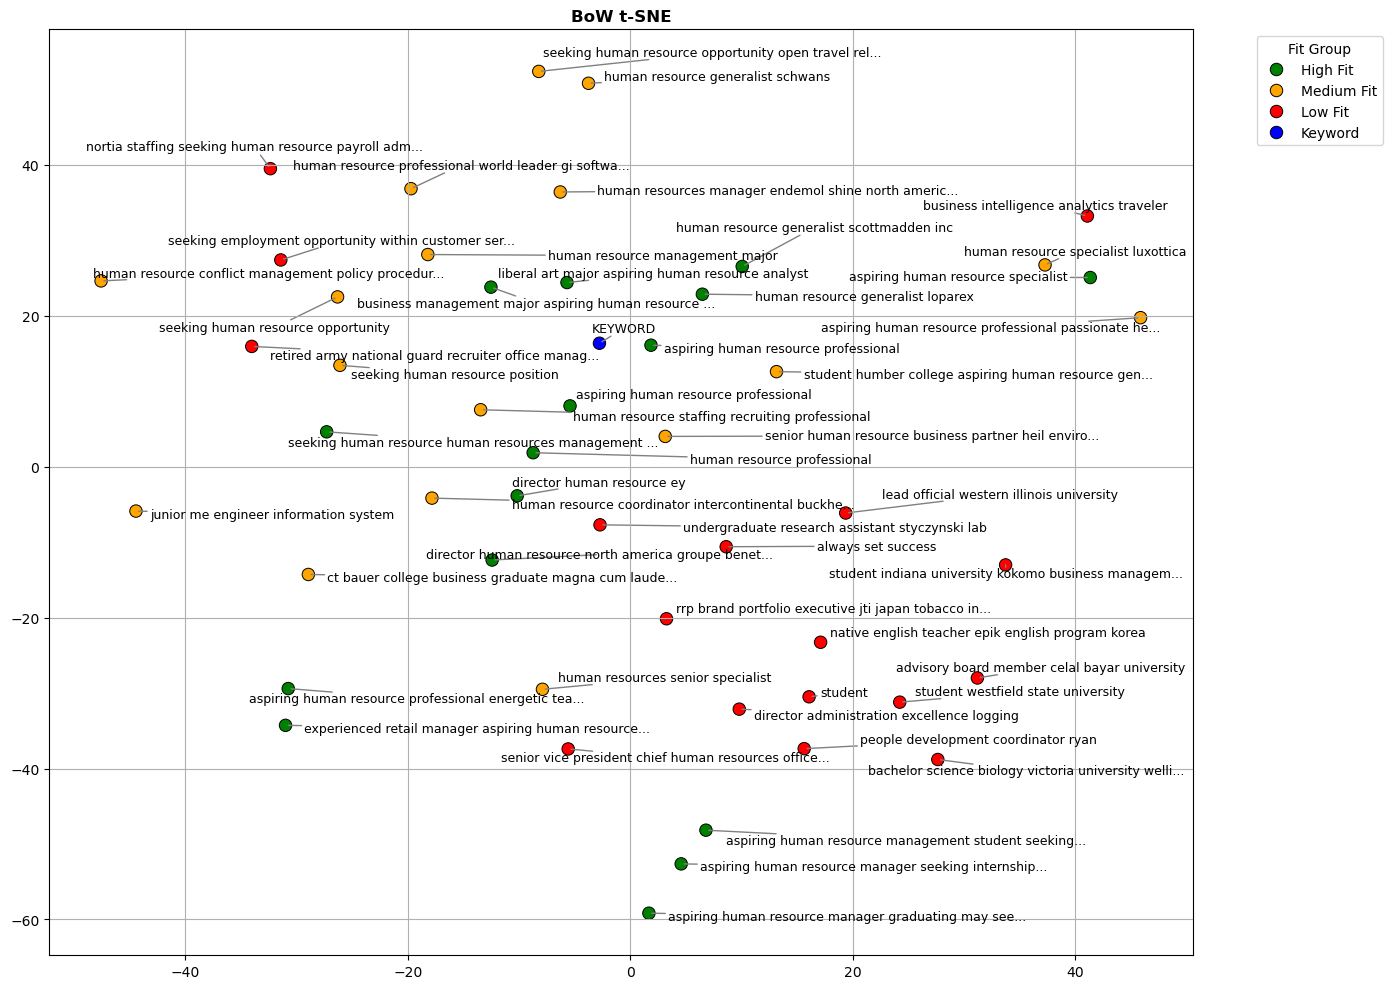

In [ ]:
ranked_candidates_df, keyword_vec = rank_candidates_BoW(keyword, processed_potential_talents)
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_BoW', keyword_vector=keyword_vec, title='BoW t-SNE')


In [7]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_BoW.csv')

In [8]:
print_candidate_table(ranked_candidates_df, vector_fit='fit_BoW')

╒════╤══════╤════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════╤══════════════╤═══════════╕
│    │   id │ job_title                                                                                          │ location                           │   connection │   fit_BoW │
╞════╪══════╪════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════╪══════════════╪═══════════╡
│  0 │    3 │ aspiring human resource professional                                                               │ raleighdurham north carolina area  │           44 │  0.866025 │
├────┼──────┼────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────┼──────────────┼───────────┤
│  1 │  101 │ human resource generalist loparex                                                          

### Term Frequency - Inverse Document Frequency (TF-IDF)
**TF-IDF (Term Frequency-Inverse Document Frequency)** is a text representation technique that builds on **Bag of Words (BoW)** but improves it by:

1. **Reducing the weight of common words** that appear frequently across many job titles (like "manager", "specialist").
2. **Boosting the importance of rare but potentially meaningful words** (like "zookeeper", "biostatistician") that may indicate more specific or unique roles.

TF-IDF combines two parts:

* **TF (Term Frequency):** Measures how often a word appears in a document (like BoW).
* **IDF (Inverse Document Frequency):** Measures how unique or rare a word is across all documents in the dataset.

**Formula:**

$$
\text{TF-IDF}(w, d) = \text{TF}(w, d) \times \text{IDF}(w)
$$

Where:

* $\text{TF}(w, d)$ = count of word $w$ in document $d$.
* $\text{IDF}(w) = \log \left( \frac{N}{n_w} \right)$,
  $N$ = total number of documents,
  $n_w$ = number of documents containing word $w$.

Thus, words that appear in **many job titles** get **lower scores**, while rare, distinguishing words get **higher scores**.

---
In this project, we’re dealing with job titles and locations as key text fields:

Many job titles share generic words: "human", "resources", "manager", "assistant".

TF-IDF reduces the influence of these words because they don’t help differentiate candidates.

Instead, TF-IDF gives more weight to specialized words like "zookeeper", "coordinator", "veterinary", or "analyst", which are better indicators of role-specific expertise.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rank_candidates_TF_IDF(keyword, df):
    """ 
    Uses TfidfVectorizer, computes cosine similarity between candidates and user keyword
    Appends the TF-IDF based fit score and embedding vectors
    """
    df = df.copy()
    df['text'] = df['job_title'] + ' ' + df['location']
    collection = df['text'].astype(str).tolist()
    collection.append(keyword)

    tfidf_vectorizer = TfidfVectorizer(max_features=300)
    vectors = tfidf_vectorizer.fit_transform(collection)

    df['embedding'] = list(vectors[:-1].toarray())
    keyword_vector = vectors[-1].toarray().flatten()

    cosine_sim = cosine_similarity(vectors[:-1], vectors[-1].reshape(1, -1))
    df['fit_tfidf'] = cosine_sim.flatten()

    ranked_candidates = df.sort_values(by=['fit_tfidf', 'connection'], ascending=[False, False])

    print('There are', ranked_candidates[ranked_candidates['fit_tfidf'] != 0].shape[0],
          'ranked candidates for the job', keyword)

    return ranked_candidates, keyword_vector


There are 42 ranked candidates for the job aspiring human resource north carolina area


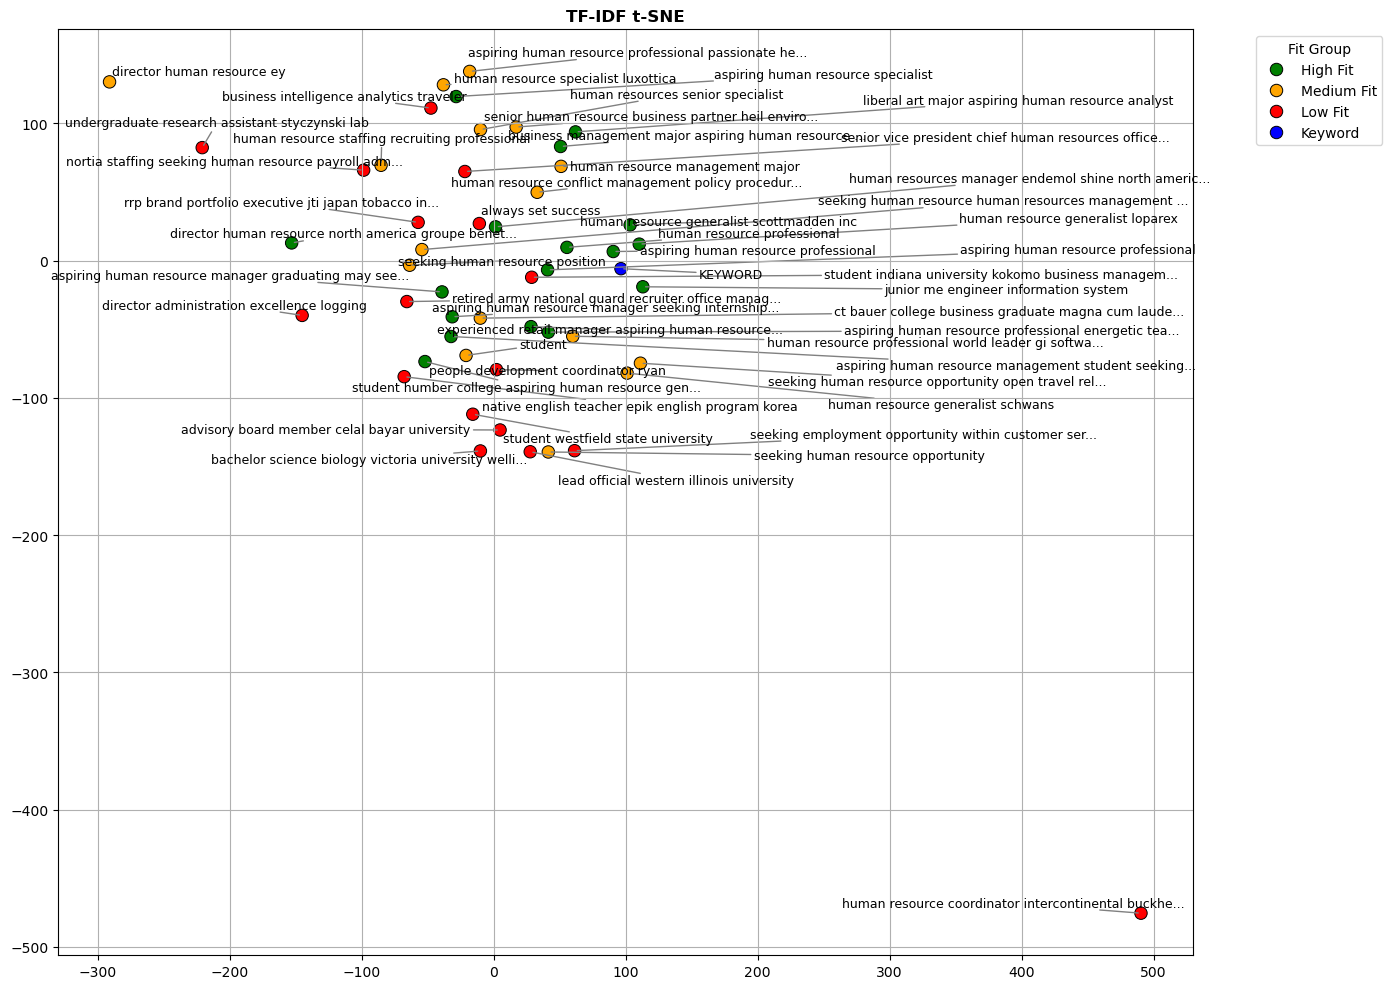

In [ ]:
ranked_df, keyword_vec = rank_candidates_TF_IDF(keyword, ranked_candidates_df)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_tfidf.csv', index=False)
plot_embedding_tSNE(ranked_df, fit_col='fit_tfidf', keyword_vector=keyword_vec, title='TF-IDF t-SNE')


In [23]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_tfidf.csv')

In [11]:
print_candidate_table(ranked_candidates_df, vector_fit="fit_tfidf")

╒════╤══════╤═══════════════════════════════════════════════════════════════════╤════════════════════════════════════╤══════════════╤═════════════╕
│    │   id │ job_title                                                         │ location                           │   connection │   fit_tfidf │
╞════╪══════╪═══════════════════════════════════════════════════════════════════╪════════════════════════════════════╪══════════════╪═════════════╡
│  0 │    3 │ aspiring human resource professional                              │ raleighdurham north carolina area  │           44 │    0.78666  │
├────┼──────┼───────────────────────────────────────────────────────────────────┼────────────────────────────────────┼──────────────┼─────────────┤
│  1 │  101 │ human resource generalist loparex                                 │ raleighdurham north carolina area  │          600 │    0.566225 │
├────┼──────┼───────────────────────────────────────────────────────────────────┼───────────────────────────────

### Word2Vec
Word2Vec is a shallow 1 hidden layer feed forward neural network based technique for learning dense vector representations of words. These vectors capture semantic meaning based on context. Words with similar meaning will have similar vectors. word2Vec learns embeddings by analyzing word co-occurence patterns in a large text corpora and produces low-dimensional dense vectors. There are two training approaches: Continuous Bag of Words which predicts a target word from its context and Skip-Gram which predicts surrounding words given a target word.  
I will be used a pre-trained Word2Vec model instead of training my own as our dataset is too small. Google News dataset will be ultizied as it is a huge dataset able to capture rich relationships. 

Google News Word2Vec is pretrained word embedding model developed by Google researchers in 2013. The model transforms individual words into dense vectors in a 300-dimensional space where semantic similarity is captured by vector distance. The architecture is a Skip-Gram series trained on the Google News dataset (~100 billion words). Skip-gram is preferred over CBOW in this instance for capturing semantic relationships in this smaller candidate dataset and better represents rare words. The skip-gram model learns to predict the surrounding words of a given target word. For example: Given the word "HR", it might learn to predict "recruiter", "human", "resources", "generalist", etc.  
As the project's goal is to rank candidates by how closely their job_title + location matches a search keyword like “aspiring human resources north carolina area”, Google News Word2Vec is useful because it is pretrained on massive data that captures general semantics of English very well. 

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

google_w2v_model_filepath = "../models/GoogleNews-vectors-negative300.bin"
w2v_model = KeyedVectors.load_word2vec_format(google_w2v_model_filepath, binary=True)
def average_word2vec(text, model, embedding_dimension = 300):
    words = text.split()
    # if word exists in model's vocab, collect word vectors
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])

    # Compute the mean vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # else if no words found in vocab, returning zero vector
        return np.zeros(embedding_dimension)
        
def rank_candidates_Word2Vec(keyword, df, model):
    """ 
    Use pretrained Google News Word2ec embeddings
    Compute average Word2Vec vector for each candidate and user keyword
    Compute cosine simlarity and append fit bassed score
    """
    df = df.copy()
    df['text'] = df['job_title'] + ' ' + df['location']
    title_location = df['text'].astype(str).tolist()

    # Compute Word2Vec average vector for each candidate
    candidate_word2vec = np.array([average_word2vec(string, model) for string in title_location])
    # Compute Word2Vec vector for keyword
    keyword_word2vec = average_word2vec(keyword, model)

    df['embedding'] = list(candidate_word2vec)
    # compute cosine similarity 
    cosine_sim = cosine_similarity(candidate_word2vec, keyword_word2vec.reshape(1,-1))  # reshape to convert keyword vector to 2d array
    # Add the word2vec fit score to the passing dataframe
    df['fit_w2v'] = cosine_sim.flatten()

    ranked_candidates = df.sort_values(by=['fit_w2v', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_w2v']!=0].shape[0],'ranked candidates for the job',keyword)

    return ranked_candidates, keyword_word2vec



There are 53 ranked candidates for the job aspiring human resource north carolina area


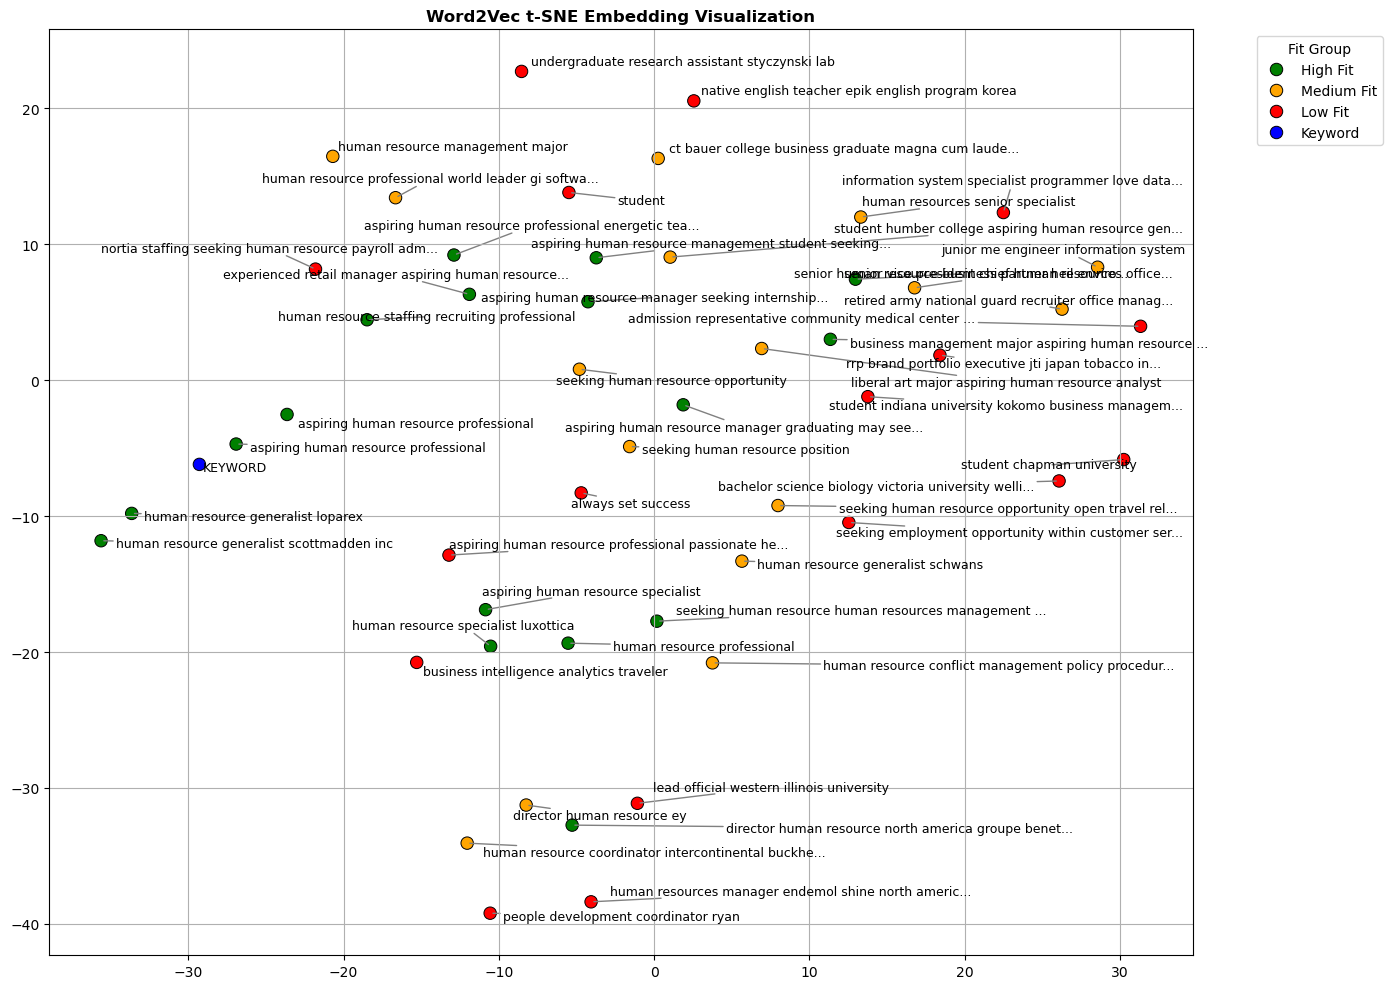

╒════╤══════╤════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════╤══════════════╤═══════════╕
│    │   id │ job_title                                                                                          │ location                           │   connection │   fit_w2v │
╞════╪══════╪════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════╪══════════════╪═══════════╡
│  0 │    3 │ aspiring human resource professional                                                               │ raleighdurham north carolina area  │           44 │  0.971718 │
├────┼──────┼────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────┼──────────────┼───────────┤
│  1 │  101 │ human resource generalist loparex                                                          

In [29]:
ranked_candidates_df, keyword_vector = rank_candidates_Word2Vec(keyword, ranked_candidates_df, w2v_model)   
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_W2V.csv', index=False)
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_w2v', keyword_vector=keyword_vector, title='Word2Vec t-SNE Embedding Visualization')
print_candidate_table(ranked_candidates_df, vector_fit="fit_w2v")


In [12]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_W2V.csv')

In [6]:
# function for 1by3 plot for fit scores of the 3 vectorization methods
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_fit_score_histograms(df, columns, cols_per_row = 3, bins=10):
    """ 
    Create bar plots for fit scores of given vectorization methods
    columns = list of vectorizaton methods, ex: fit_BoW, fit_tf-idf...
    """
    total = len(columns)
    rows = math.ceil(total / cols_per_row)
    
    plt.figure(figsize=(5 * cols_per_row, 4 * rows))

    for i, col in enumerate(columns):
        plt.subplot(rows, cols_per_row, i+1)
        #plt.bar(range(len(df)), df[col])
        plt.hist(df[col].dropna(), bins=bins, edgecolor='black')
        plt.title(f'{col} Fit Score Distribution')
        plt.ylabel('Frequency')
        plt.xlabel('Cosine Similarity')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

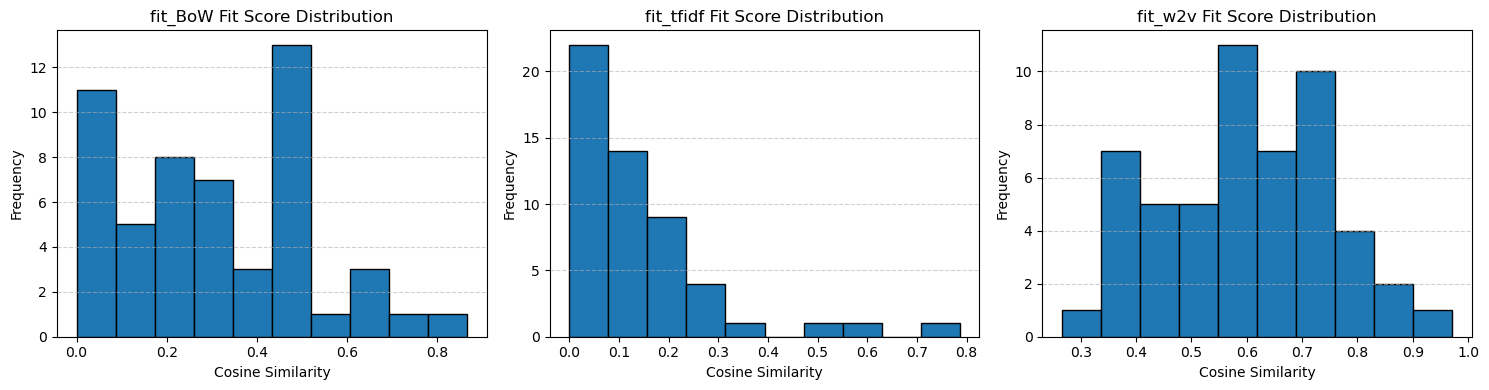

In [ ]:
plot_fit_score_histograms(ranked_candidates_df, ['fit_BoW', 'fit_tfidf', 'fit_w2v'])

Based on the fit scores for Google News Word2Vec, we see highly relevant job titles have fit score range from ~0.97 to 0.74. The candidates contain both semantic matches in job titles and sometimes geographical overlap. The model has good filtering of irrelevant candidates as they received low similarity scores as expected. As this method relies on averaging which reduces context, the model wil have trouble with multi-word phrase. The Google News Word2Vec model outperforms both BoW and TF-IDF as it captures semantic similarity beyond exact word match, gives higher scores to conceptually relevant profiles even if word usage differs.  

The histrograms show the distribution of cosine similarity scores from the following vectorization methods: Bag of Words, TF-IDF, and Word2Vec. Based on the BoW graph, the distribution is skewed left to low scores and a few moderate to high outliers. BoW depends on exact word overlap and many candidates have low or zero overlap with the keyword. The limitation of this method is that there is no understandin of meaning or context leading to poor generalization. The Term Frequency-Inverse Document Frequency historgram also shows a heavily left skewed distribution towards very low similarity range. Like BoW, TF-IDF relies on exact word match but boosts rare, informative words. This metho is still context insensitive and can not identify conceptual similarity. Word2Vec's fit distribution is more uniformly spread out. We can infer it captures semantic meaning, almost all candidates get non zero scores, and high scoring candidates are conceptually close even with different wording. Google's Word2Vec model has a strong ability to discriminate relevance on a conceptual level. 



### GloVe (Global Vectors for Word Representation)
GloVe (developed by Stanford NLP) is an unsupervised learning algorithm for generating dense vector representations of words (embeddings) based on word co-occurence statistics from a large corpus. Similar to Word2Vec, GloVe creates vector embeddings where semantically similar words have similar vectors but their training approach differs.  

The core idea of GloVe is that it can understand the meaning of a word by how often it co-occurs with other words, not just locally like Word2Vec, but globally across the corpus. At the heart of GloVe is a co-occurence matrix which is a glocal statiscal summary of how words appear together in a corpus. Its a square matrix X of size V by V where V  is the size of the vocabulary (number of unique words). The matrix is useful because the ratio of co-occurrence counts between two word pairs reveals semantic relationships. For example: $$\frac{X_{ice, solid}}{X_{ice,gas}} > \frac{X_{steam, solid}}{X_{steam,gas}}$$ reflects that 'Ice' is related to 'solid' and not 'gas' while 'steam' is related to 'gas' and not 'solid'. $w_i$ and context vectors $\tilde{w}_j$ such that:

$$
w_i^T \cdot \tilde{w}_j + b_i + \tilde{b}_j = \log(X_{ij})
$$

The model tries to ensure:

* The dot product of two word vectors matches the **log of how often they appear together** in the global corpus.

Using a pretrained GloVe model glove.6B.300d.txt, which is one of Stanford's NLP's official pretrained GloVe embeddings. The pretrained model "glove.6B.300d.txt" is trained on 6 billion tokens from a Wikipedia + Gigaword dataset where each word is represented by a 300-dimensional vector.


In [30]:
# load pretrained GloVe embedding glove.6B.300d.txt. Can find the file at Stanford NLP group's GloVe page
# https://nlp.stanford.edu/projects/glove/ 
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# function to convert .txt GloVe file into Word2Vec Format 
def convert_glove_to_word2vec(glove_file_path, word2vec_output_path):
    glove2word2vec(glove_file_path, word2vec_output_path)

# Load pretrained GloVe to return a KeyedVectors object
def load_glove_model(word2vec_output_path):
    model = KeyedVectors.load_word2vec_format(word2vec_output_path, binary=False)
    return model

# Average GloVe embedding for a candidate string
def get_average_glove(text, model, dim=300):
    """ 
    Transforms candidates text or keyword query into fixed size vector to allow for comparison
    between candidates and query in a shared embedding space and use cosine similarity
    """
    words = text.split()
    # collecting vectors for in-vocab words only, otherwise return 0 vector
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)     # average across all words
    else:
        return np.zeros(dim)
    
def rank_candidates_GloVe(keyword, df, model, embedding_dim=300):
    """ 
    Rank candidates in terms of semantic similarity to the user query using dense vector representation.
    Also returns keyword vector for visualization.
    """
    df = df.copy()
    df['text'] = df['job_title'] + ' ' + df['location']
    combined_text = df['text'].astype(str).tolist()

    candidate_vectors = np.array([get_average_glove(text, model, embedding_dim) for text in combined_text])
    keyword_vector = get_average_glove(keyword, model, embedding_dim)

    df['embedding'] = list(candidate_vectors)
    cosine_sim = cosine_similarity(candidate_vectors, keyword_vector.reshape(1, -1))
    df['fit_glove'] = cosine_sim.flatten()

    ranked_candidates = df.sort_values(by=['fit_glove', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_glove'] != 0].shape[0],
          'ranked candidates for the job', keyword)

    return ranked_candidates, keyword_vector


In [33]:
glove_filepath = "../models/glove.6B.300d.txt"
# Convert the GloVe file once
convert_glove_to_word2vec(glove_filepath, "../models/glove.6B.300d.word2vec.txt")
# Load the converted file
glove_model = load_glove_model("../models/glove.6B.300d.word2vec.txt")



C:\Users\aduro\AppData\Local\Temp\ipykernel_4472\1138765221.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_path)


In [40]:
ranked_candidates_df, keyword_vec = rank_candidates_GloVe(keyword, ranked_candidates_df, glove_model)
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_glove', keyword_vector=keyword_vec, title='GloVe t-SNE')
print_candidate_table(ranked_candidates_df, vector_fit="fit_glove")


AttributeError: 'tuple' object has no attribute 'copy'

In [41]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_GloVe.csv')


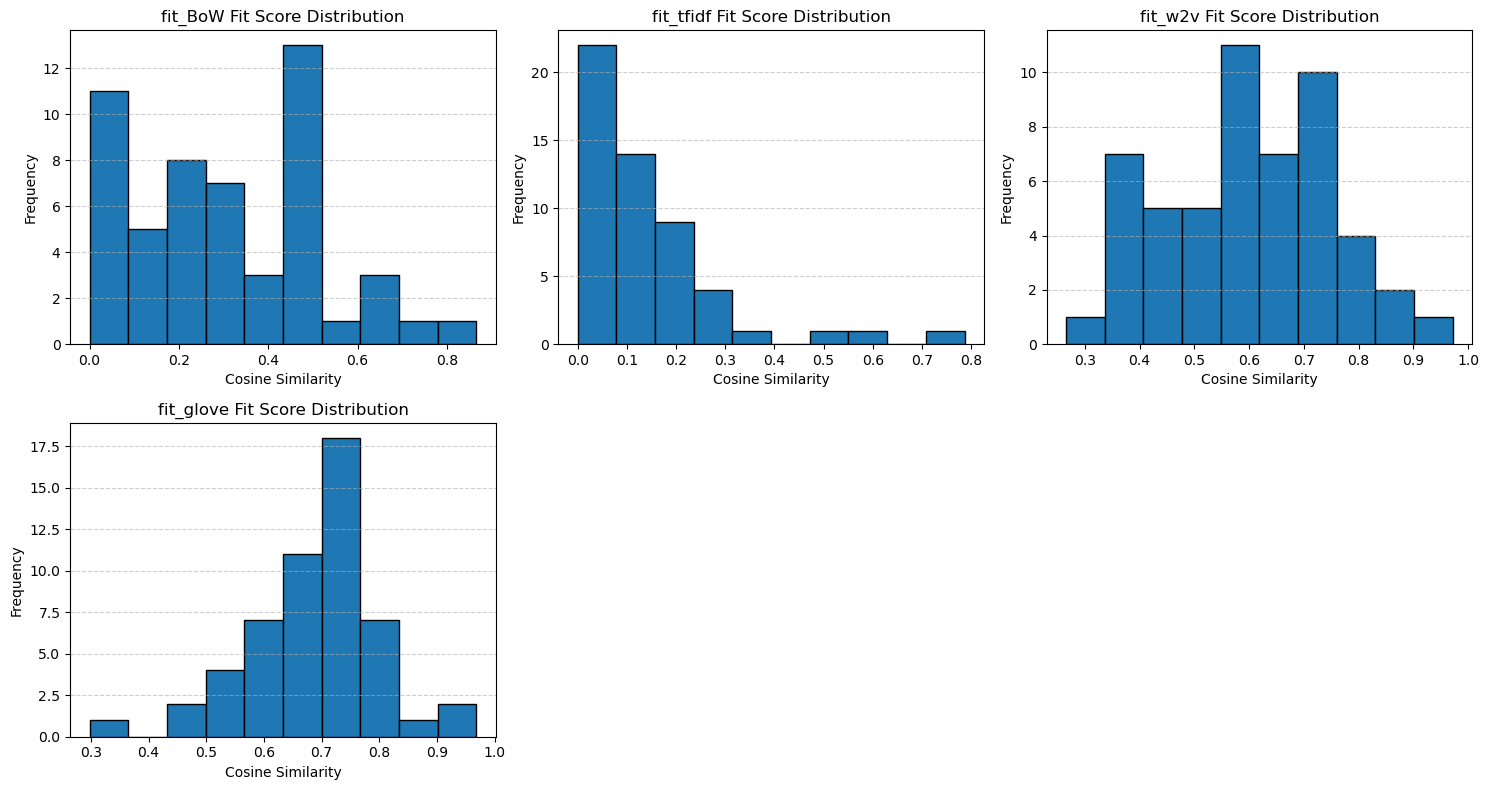

In [11]:
plot_fit_score_histograms(ranked_candidates_df, ['fit_BoW', 'fit_tfidf', 'fit_w2v', 'fit_glove'])

#### Visualizing GloVe results

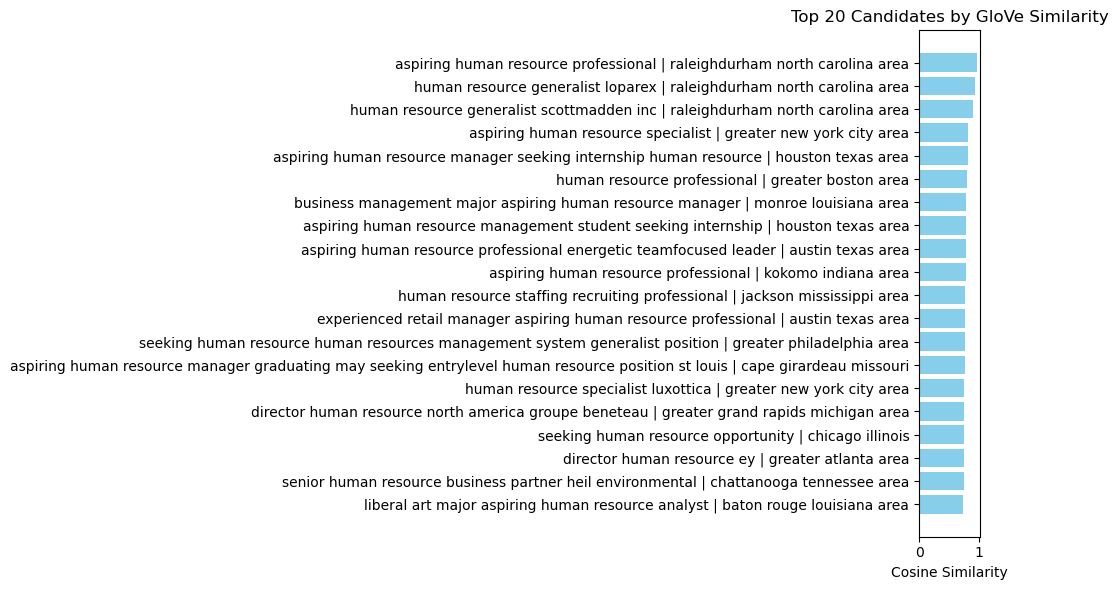

In [23]:
import matplotlib.pyplot as plt

def plot_glove_fit_scores(df, top_n=20):
    top_candidates = df.sort_values(by='fit_glove', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_candidates['job_title'] + ' | ' + top_candidates['location'], top_candidates['fit_glove'], color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Top {top_n} Candidates by GloVe Similarity")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_glove_fit_scores(ranked_candidates_df)

### Using t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is a nonlinear dimensionality reduction algorithm used to visualize high-dimensional data in 2D or 3D by preserving local similarities. Word embeddings (GloVe) are high-dimensional 300D, and we can't visualize 300D space directly. t-SNE reduces these to 2D while preserving the structure of word similarity (local neighborhoods). Computes pairwise similarities between points in high-dimensional space (based on a probability distribution over neighbors). Then it projects the data into a low-dimensional space (2D or 3D). Minimizes the divergence between the two distributions (high-D and low-D) using Kullback-Leibler (KL) divergence. Uses a heavy-tailed Student-t distribution in the low-dimensional space to avoid crowding.

The figure is a t-SNE visualization of GloVe embeddings for candidates, designed to show their semantic similarity to a user defined keyword based on job title and location. It represents a 2D projection of the 300 dimensional GloVe embeddngs reduced via t-SNE. Points that are closer together are more semantically similar. The blue 'KEYWORD' point represents the semantic center of what the user is looking for: someone aspiring (entry level), in human resources and located in North Carolina. Candidates close to the keyword (green dots) are semantically similar candidates likely to be entry level candidates in HR, having job titles including relating to 'aspiring' and located in regions close to North Carolina. 

### FastText  
Developed by Facebook AI Research (FAIR), FastText is a word embedding model that improves upon Word2Vec by incorporating subword information into word representations. Basing on character n-grams allows the model to infer embeddings for unseen out of vocabulary words, which was a major limitation of Word2vec and GloVe. 
How FastText Works
1. Subword Modeling
Each word is broken down into a bag of character n-grams (e.g., 3-6 characters).

For example, the word where with 3-grams becomes:
"<wh", "whe", "her", "ere", "re>"
where < and > are boundary markers.

A word vector is obtained by summing or averaging the vectors of its subword n-grams.

2. Training Objective
Similar to Word2Vec's Skip-gram with Negative Sampling (SGNS):

Predict context words from a target word

But instead of using a single word vector, FastText:

Uses the sum of subword vectors to represent each target or context word

3. Example
Suppose you're training on the sentence:
I enjoy playing football
The word "football" might be represented using:

"foo", "oot", "otb", "tba", "bal", "all"

Each of these n-grams has its own embedding, and the final "football" vector is a composition of its subword parts.

I will be using a pretrained FastText embedding model provided by Facebook AI Research called 'cc.en.300.vec'. This pretrained model is trained on the Common Crawl database which is a publicly massive web-scale dataset which provides a wide vocabulary coverage. Vector dimension is 300. Each line in 'cc.en.300.vec' is a token for the word and the next 300 numbers are the embedding vector for that word. 

In [37]:
import numpy as np
from gensim.models.fasttext import load_facebook_vectors    # loading FB's pretrained FastText model
from sklearn.metrics.pairwise import cosine_similarity 


def get_average_fasttext(text_string, model, vector_size=300):
    """ 
    Convert text string into a single fixed-sized vector by averaging word embeddings
    """
    # Return zero vector if text is empty
    if not isinstance(text_string, str) or text_string.strip() == "":
        return np.zeros(vector_size)
    
    words = text_string.lower().split()
    vectors = []
    # retrieve vector from FastText model from each word
    for word in words:
        try:
            vectors.append(model[word])
        except KeyError:
            continue
    # Return zero vector if no valid word vectors were found
    if not vectors:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

def rank_candidates_FastText(df, keyword, model, vector_size=300):
    """ 
    Obtain cosine similarity between candidate and keyword vectors using FastText, append fit score to passing dataframe
    """
    df = df.copy()
    df['text'] = df['job_title'] + ' ' + df['location']
    combined_text = df['text'].astype(str).tolist()
    
    # Computing cosine similarity fit score
    # convert list of 300D vectors inot 2D numpy array where each row is candidate vector and column is FastText dimension
    candidate_vectors = np.array([get_average_fasttext(text, model) for text in combined_text])
    keyword_vector = get_average_fasttext(keyword, model, vector_size)

    df['embedding'] = list(candidate_vectors)
    cosine_sim = cosine_similarity(candidate_vectors, keyword_vector.reshape(1,-1))
    df['fit_fasttext'] = cosine_sim.flatten()

    ranked_candidates = df.sort_values(by=['fit_fasttext', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_fasttext']!=0].shape[0],'ranked candidates for the job',keyword)

    return ranked_candidates,keyword_vector



In [38]:

# Load Facebook's pretrained FastText model 'cc.en.300.bin'
fasttext_model = load_facebook_vectors('../models/cc.en.300.bin')


There are 53 ranked candidates for the job aspiring human resource north carolina area


AttributeError: 'tuple' object has no attribute 'to_csv'

There are 53 ranked candidates for the job aspiring human resource north carolina area


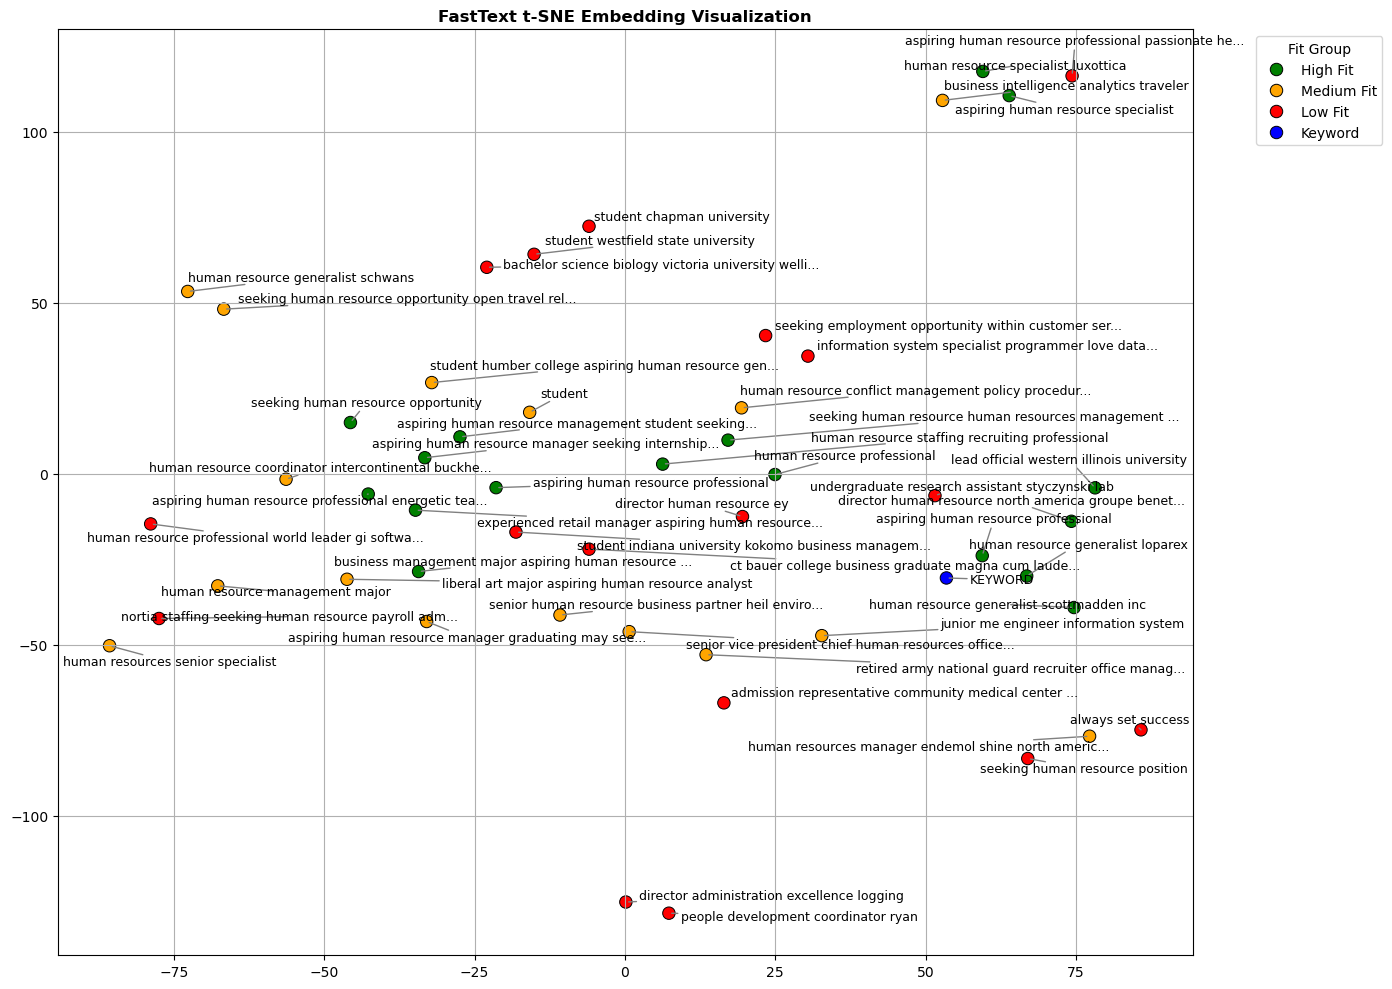

╒════╤══════╤══════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════╤══════════════╤════════════════╕
│    │   id │ job_title                                                                    │ location                           │   connection │   fit_fasttext │
╞════╪══════╪══════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════╪══════════════╪════════════════╡
│  0 │    3 │ aspiring human resource professional                                         │ raleighdurham north carolina area  │           44 │       0.983404 │
├────┼──────┼──────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────┼──────────────┼────────────────┤
│  1 │  101 │ human resource generalist loparex                                            │ raleighdurham north carolina area  │          600 │       0.921425 │
├────┼──────┼───────────────

In [42]:
ranked_candidates_df, keyword_vec = rank_candidates_FastText(ranked_candidates_df, keyword, fasttext_model)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_FastText.csv', index=False)
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_fasttext', keyword_vector=keyword_vec, title='FastText t-SNE Embedding Visualization')
print_candidate_table(ranked_candidates_df, vector_fit="fit_fasttext")

In [5]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_FastText.csv')

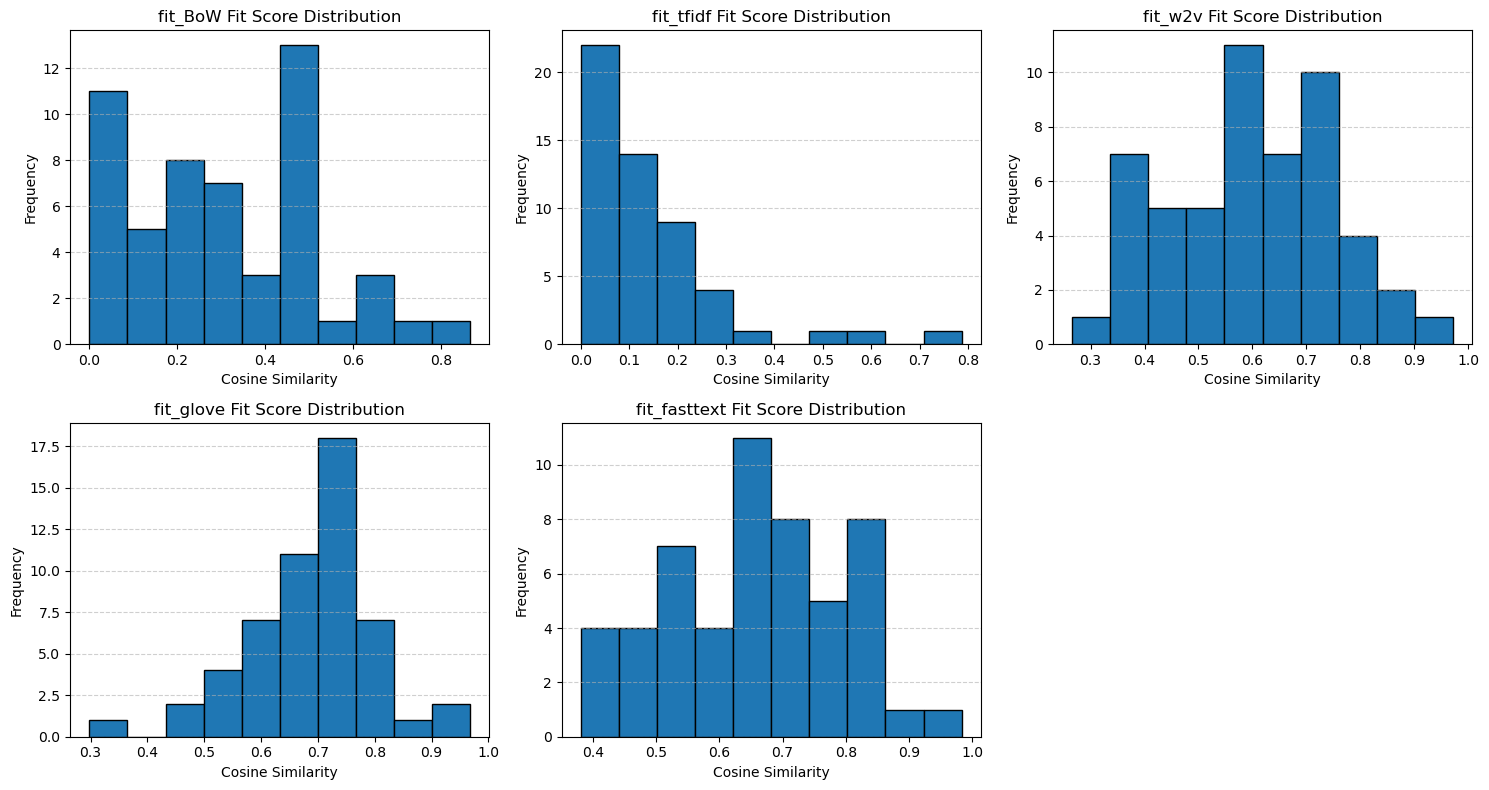

In [8]:
plot_fit_score_histograms(ranked_candidates_df, ['fit_BoW', 'fit_tfidf', 'fit_w2v', 'fit_glove', 'fit_fasttext'])

From this histogram plot, I can infer from FastText's distribution, its shape is nearly normal with a slight right skew. FastText's distribution is less peaky than GloVe which clusters around 0.75 and more spread out than Word2Vec which suggests broader generalization. 

Top candidates have job titles that are semantically close to the keyword (aspiring human resources north carolina area), even if phrasing or spelling differs
The location and job title pairings are better matched with FastText than TF-IDF or BoW because:
FastText understands morphology (HR, recruiter, talent) and regional name variations
It generalizes OOVs, helping with informal job titles (e.g., “aspiring recruiter”)

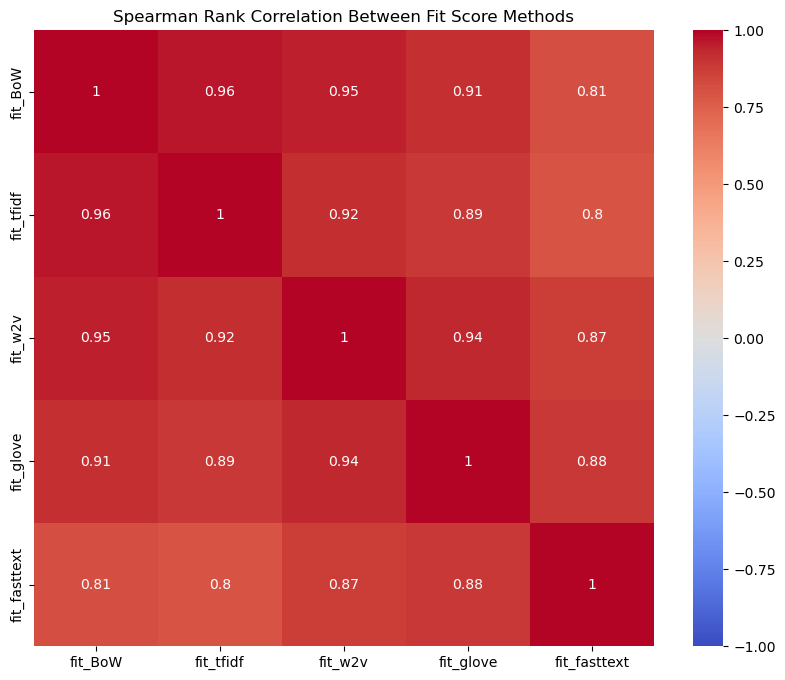

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

fit_columns = [
    'fit_BoW',
    'fit_tfidf',
    'fit_w2v',
    'fit_glove',
    'fit_fasttext'
]

# compute correlation matrix 
# Compute correlation matrix
corr_matrix = pd.DataFrame(index=fit_columns, columns=fit_columns)

for i in fit_columns:
    for j in fit_columns:
        rho, _ = spearmanr(ranked_candidates_df[i], ranked_candidates_df[j])
        corr_matrix.loc[i, j] = round(rho, 3)

# Convert to float type for plotting
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Rank Correlation Between Fit Score Methods")
plt.show()

### BERT (Bidirectional Encoder Representations from Transformers) 
Bert is a transformer-based language model developed by Google AI in 2018, revolutionizing NLP by introducing deep bidirectional context modeling. Pretrained on a massive text corporta, it is fine-tuned for specific downstream tasks. Prior models like GloVe and Word2Vec assign static vectors to words and dont consider context, ex: bank in 'river bank' and 'credit bank' have the same vector. BERT departs from this methodlogy by ultizing transformers to to model contextualized embeddings, process text strings bidirectionally and output different embeddings for the same word depending on context. 

Based on the Transformer Encoder stack (Vaswani et al., 2017), BERT embeddes each token using token embeddings (WordPiece vocabulary), segment embeddings (to distinguish sentence pairs), and position embeddings (since transformers have no recurrence). BERT is pretrained using two self-supervised tasks: Masked Language Modeling (MLM) and Next Sentence Prediction (NSP). MLM randomly masks ~15% of input tokens and trains to predict them, which forces the model to understand both left and right context. 

Transformers are a neural architectue based on self-attention, introduced in the 2017 paper "Attention is All You Need" (Vaswani et al., 2017). Self-attention is a mechanism that allows a model to weigh the importance of different tokens in a sequence when encoding each word. Self-attention allows each token to compute a weighted average of all tokens in the sequence, assign more weight to relevant words and capture contextual relationships irregardless of the distance. As a result, transformers do not process tokens sequentially, allow each token to attend to all other tokens in the sentence, and stack multiple encode layers with each of them futher refining the representations

Each transformer layer consists of:  
* Multi-head self-attention: captures multiple types of relationships 
* Feed-forward layers: transforms the attention-weighted inputs
* Residual connections + layer normalization

In Bert, each token is updated layer-by-layer based on its relationships with all other tokens in the input. This creates contextualized embeddings, where 'developer' depends on the sentence its in. Bert processes text bidirectionally (left and righ simultaneously) while traditional methods are unidirectional from left to right. BERT uses Masked Language Modeling (MLM), where it randomly masks a word, then looks both left and right to predict it. Bidirectionality matters because it enables BERT to understand the full meaning of a word, sentence or phrase: 

* "bat" in “The bat flew in the cave” (animal)
* "bat" in “He swung the bat hard” (sports equipment)

Every token's final embedding is the result of self-attention across all layers. Therefore, even the same word gets different representations depending on the surrounding words, sentence structure and position in sentence. 

In [41]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

# Load BERT-base Model and Tokenizier
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model.eval() # disable dropout

def rank_candidates_BERT(df, query_text, model, tokenizer, max_length=64):
    """ 
    Use bert-based-uncased, tokenizes candidate text and query, compuytes the average token embedding, calculates cosine similarity fit scores
    and returns the dataframe with the fit BERT score. 
    Parameters:
    - model: pretrained BERT model
    - tokenizer: matching BERT tokenizer
    - max_length: max token length for truncation
    """
    df1 = df.copy()
    def get_avg_embedding(text):
        # tokenize the text into a format BERT expects
        input_tokenized = tokenizer(text, return_tensors='pt', truncation=True, padding=True , max_length=max_length)
        # Feed the tokenized inputs into the pretrained BERT model
        with torch.no_grad():   # run in inference mode, disabling gradient tracking
            outputs = model(**input_tokenized)
        # Extract token embeddings, obtaining a matrix of token embeddings
        last_hidden = outputs.last_hidden_state.squeeze(0)
        # returning single 768-dim vector returns NumPy array
        return last_hidden.mean(dim=0).numpy()
    # convert the user query into BERT vector
    query_vec = get_avg_embedding(query_text)

    # combine candidate's datainto a single text string into a 768 dimensional average BERT vector
    combined_texts = (df1['job_title'] + ' ' + df1['location']).tolist()
    candidate_vectors = np.array([get_avg_embedding(text) for text in combined_texts])

    # Compute cosine similarity between candidate vector and query vector
    # reshape(1,-1) to ensure query is in shape (1,768) and flatten() to 1D array
    df1['embedding'] = list(candidate_vectors)
    similarity_scores = cosine_similarity(candidate_vectors, query_vec.reshape(1,-1)).flatten()   
    df1['fit_BERT'] = similarity_scores

    df1 = df1.sort_values(by=['fit_BERT', 'connection'], ascending=[False, False])
    print('There are', df1[df1['fit_BERT']!=0].shape[0],'ranked candidates for the job',keyword)

    return df1, query_vec



In [44]:
ranked_candidates_df, keyword_vec = rank_candidates_BERT(processed_potential_talents, keyword, bert_model, tokenizer)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_BERT.csv', index=False)

There are 53 ranked candidates for the job aspiring human resource north carolina area


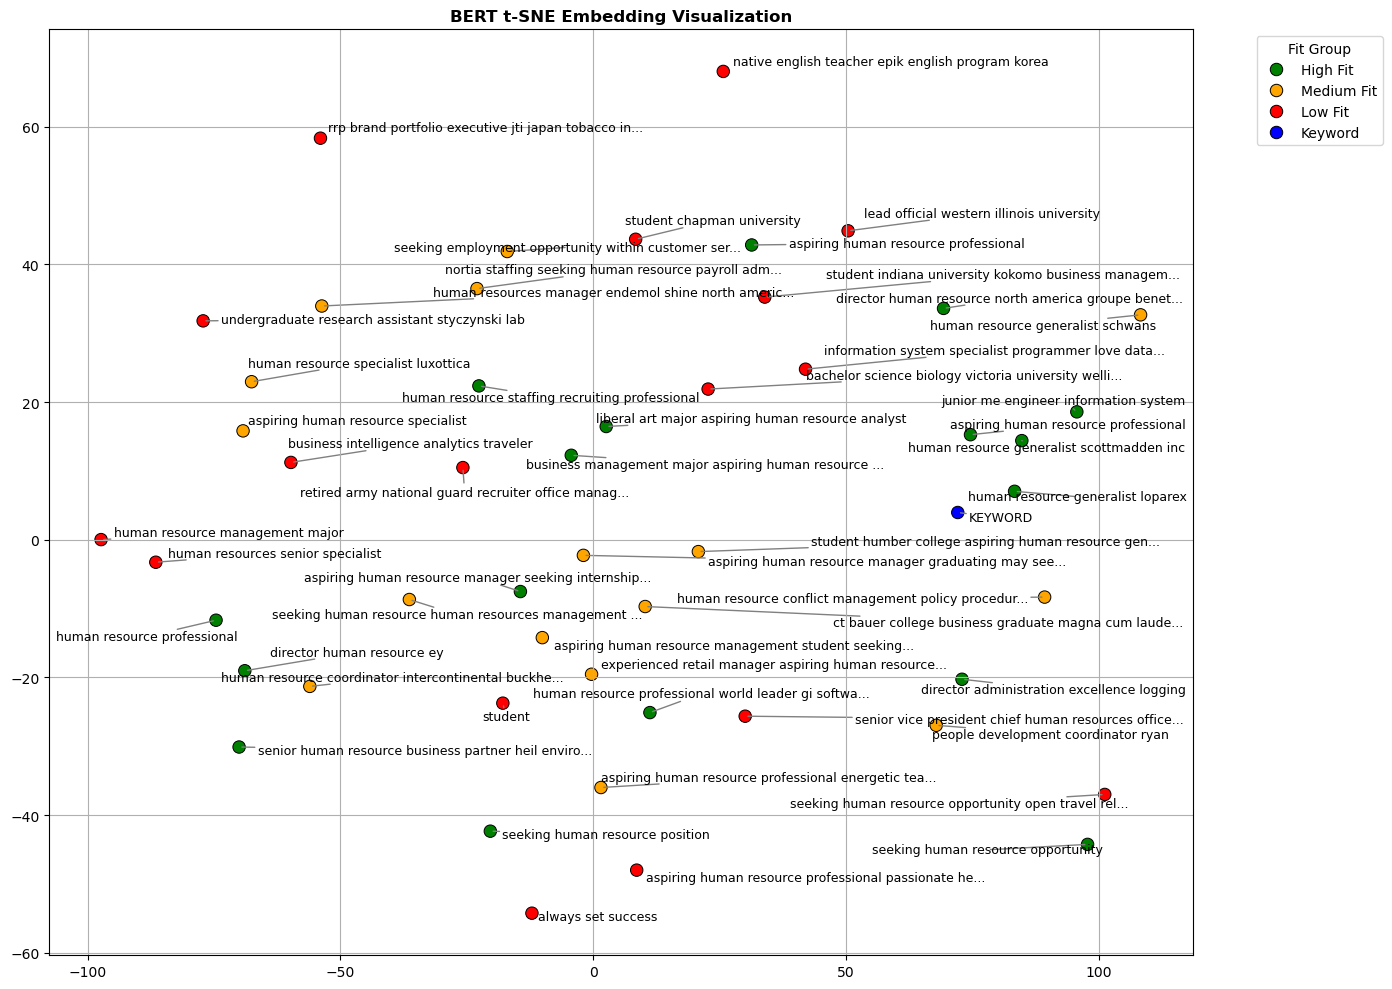

╒═════╤══════╤═══════════════════════════════════════════════════════════════════╤════════════════════════════════════╤══════════════╤════════════╕
│     │   id │ job_title                                                         │ location                           │   connection │   fit_BERT │
╞═════╪══════╪═══════════════════════════════════════════════════════════════════╪════════════════════════════════════╪══════════════╪════════════╡
│ 100 │  101 │ human resource generalist loparex                                 │ raleighdurham north carolina area  │          600 │   0.867706 │
├─────┼──────┼───────────────────────────────────────────────────────────────────┼────────────────────────────────────┼──────────────┼────────────┤
│   2 │    3 │ aspiring human resource professional                              │ raleighdurham north carolina area  │           44 │   0.864575 │
├─────┼──────┼───────────────────────────────────────────────────────────────────┼──────────────────────────────

In [45]:
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_BERT', keyword_vector=keyword_vec, title='BERT t-SNE Embedding Visualization')
print_candidate_table(ranked_candidates_df, vector_fit="fit_BERT")

In [6]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_BERT.csv')

This t-SNE plot shows a tight clustering of several green (high-fit) and orange (medium-fit) points around the keyword in 2D space. This is a positive signal as it means BERT is identifying semantically similar profiles. BERT average embeddings meaningfully separate semantically similar candidates as top matching profiles are close in both cosine score and t-SNE space

### SBERT Sentence Bert 
Sentence-BERT is a modification of the BERT architecture that is designed specifically to generate meaningful sentence embeddings that can be compared with cosine similarity. The base BERT model was trained for token level tasks, classification task and using [CLS] token for classification heads. However, BERT was not trained to produce sentence embeddings that can be directly compared using cosine similarity. SBERT makes two critical additions to turn BERT into a sentence embedding model:
* Triplet Architecture:
  - SBERT feeds two or three sentences into parallel BERT models and encodes each sentence into a fixed-size vector. 
  - Optimizes these vectors so that similar sentences are close together and dissimilar sentences are far apart.  
* Training Objectives:
  - SBERT introduces the following training losses that directly optimize cosine similarity. 
  - Cosine Similarity Loss : Align sentence embeddings for known paraphrase pairs.
  - Triplet Loss : Anchor should be closer to the positive sentence than to the negtive one. 
  - Multiple Negative Ranking Loss : Used for training on large batch negatives. 
  
SBERT has the same BERT internals but just adds a sentence level training mechanism on top of it. 

In [ ]:
from sentence_transformers import SentenceTransformer, util 
import numpy as np
# check different model checkpoints 
# Load SBERT model once 
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def rank_candidates_SBERT(df, query, model):
    """ 
    Compute semantic similarity fit scores using a pretrained SBERT Sentence Transformer.
    """
    # Combine candidate text into a unified field
    combined_text = (df['job_title'] + ' ' + df['location']).tolist()

    # Encode Candidate and Keyword texts using model.encode() to convert text into dense sentence embeddings
    # convert_to_tensor=True, returns PyTorch tensors for fast computation
    # normalize_embeddings=True, L2-normalizes each vector
    candidate_embeddings = model.encode(combined_text, convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model.encode(query, convert_to_tensor=True, normalize_embeddings=True)

    df['embedding'] = [emb.cpu().numpy() for emb in candidate_embeddings]
    # Compute cosine similarity 
    cosine_scores = util.cos_sim(candidate_embeddings, query_embedding).cpu().numpy().flatten()
    df['fit_SBERT'] = cosine_scores

    ranked_candidates = df.sort_values(by=['fit_SBERT', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_SBERT']!=0].shape[0],'ranked candidates for the job', query)

    return ranked_candidates, query_embedding.cpu().numpy()


In [ ]:
ranked_candidates_df, keyword_vec= rank_candidates_SBERT(ranked_candidates_df, keyword, sbert_model)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_SBERT.csv')

There are 53 ranked candidates for the job aspiring human resource north carolina area


In [ ]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_SBERT.csv')

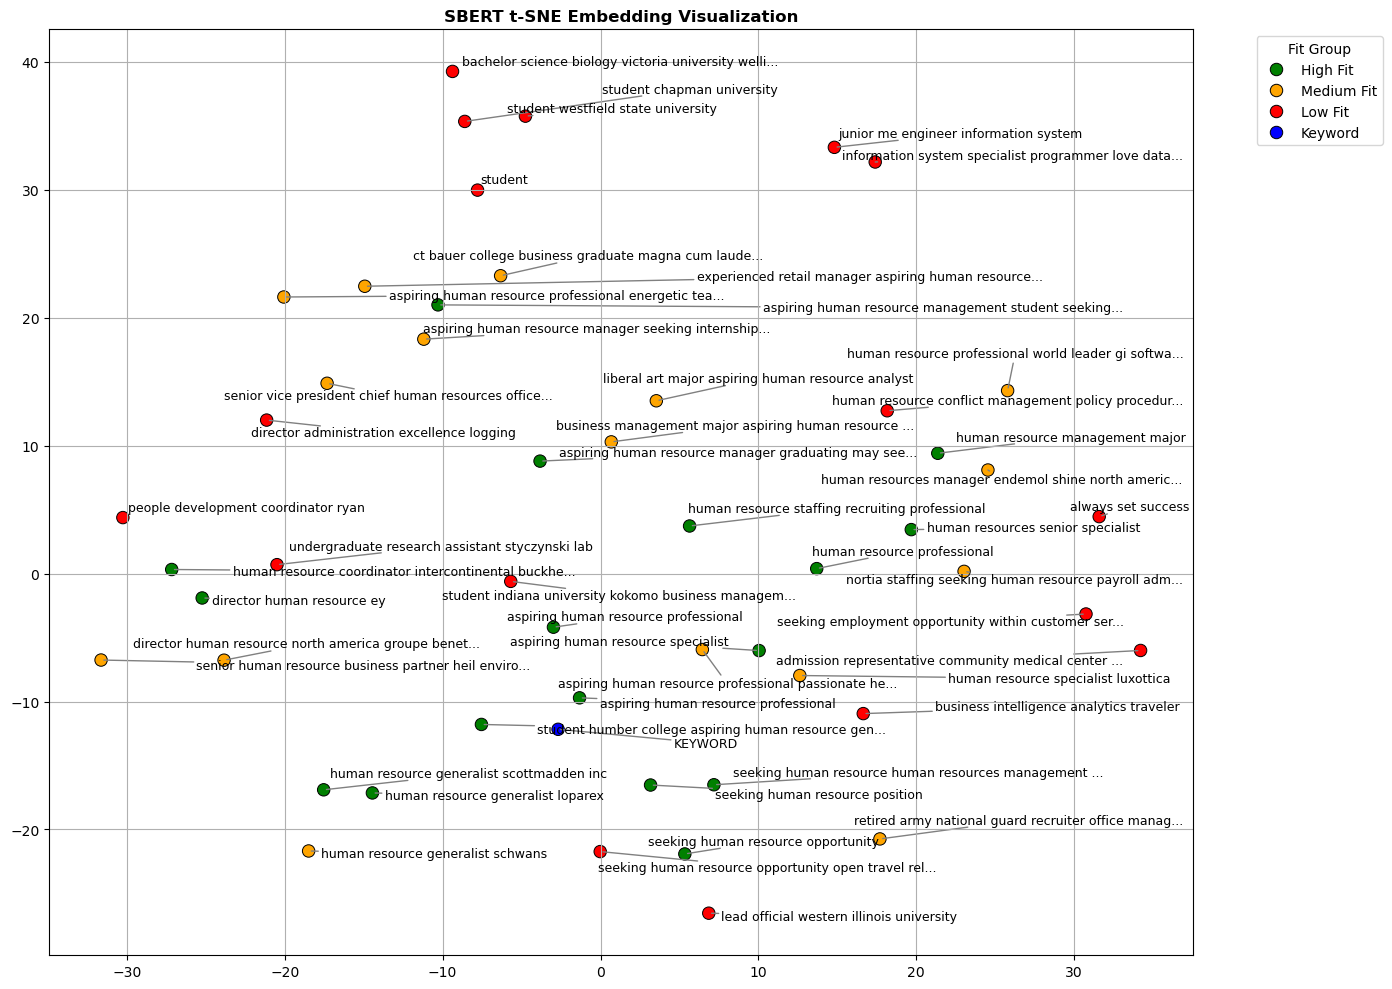

╒════╤══════╤════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════╤══════════════╤═════════════╕
│    │   id │ job_title                                                                                          │ location                          │   connection │   fit_SBERT │
╞════╪══════╪════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════╪══════════════╪═════════════╡
│  0 │    3 │ aspiring human resource professional                                                               │ raleighdurham north carolina area │           44 │    0.928272 │
├────┼──────┼────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────┼──────────────┼─────────────┤
│  3 │    6 │ aspiring human resource specialist                                                    

In [ ]:
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_SBERT', keyword_vector=keyword_vec, title='SBERT t-SNE Embedding Visualization')
print_candidate_table(ranked_candidates_df, vector_fit="fit_SBERT")

SBERT's t-SNE embedding plot has the best spatial clustering of all the embedding methods utlizied so far. We can see that most of the high-fit green candidates are tightly grouped near the keyword while the medium and low fit candidates are progressively farther out, showing a clear spatial gradient. This alignment strongly suggests SBERT captures semantic proximity very well.

Following insights from the SBERT t-SNE plot:
1. Strong Spatial Clustering by Semantic Fit
* High-fit candidates (green) are tightly grouped near the keyword (blue dot).
* Medium-fit (orange) and low-fit (red) candidates are progressively farther out, showing a clear spatial gradient.
* This spatial alignment strongly suggests SBERT captures semantic proximity very well.

Implication: Cosine similarity in SBERT embedding space correlates well with actual human-perceived job-role similarity. 

2. Keyword Anchoring Works
* The KEYWORD vector sits naturally at the center of the green cluster.
* This reflects accurate geometric placement: the query is semantically closest to high-fit candidates, as it should be.
Compare this to BERT or GloVe plots, where the keyword might have:
* Floated away from relevant points (GloVe)
* Had no clear gradient of fit score with distance (BERT)

3. Semantic Smoothness
* Transition from high → medium → low fit is smooth and consistent across 2D space.
* In contrast, BoW/TF-IDF plots often show jumbled or binary patterns, with sharp boundaries but no semantic continuity.
* GloVe and FastText show some grouping, but less precise anchoring around the keyword.

SBERT embeddings encode semantic meaning at the sentence level, not just word-level overlap or subword similarity.



**Why SBERT Is the Best Embedding Model for the Potential Talents Project**

The project is centered around ranking job candidates by how well they semantically match a given job query. Each of the candidate's profile is defined by two key features: job title, and location. The goal is to compute a cosine similarity-based fit score between a candidate's profile and a given query, using text embeddings. Several embedding methods have been evaluated: Bag of Words (BoW), TF-IDF, Word2Vec, GloVe, FastText, BERT, and SBERT. Among all these, SBERT (Sentence-BERT) emerges as the most effective and appropriate model for this project. Here's why:

**1. SBERT is trained for semantic similarity** 

Unlike BERT, which was originally trained for masked language modeling and next sentence prediction, SBERT is explicitly fine tuned for sentence level similarity tasks. It uses a triplet network structure, allowing it to directly optimize cosine similarity between semantically similar sentences. This is essential for this project as  I am not doing classification or token level prediction, but rather comparing semantic content across different candidates.

2\. Sentence-level embeddings are essential for this project.&#x20;

Unlike SBERT, models like Word2Vec, GloVe, and FastText generate embeddings for individual words rather than entire sentences. This approach involves  aggregating word vectors to create a sentence level representation. This  loses contextual nuance and can not effectively capture the meaning of multi-word expressions or sentence structure. SBERT, on the other hand, produces high-quality, context-aware sentence embeddings that maintain the holistic meaning of the candidate profile text.

3.  Cosine similarity in SBERT space reflects semantic closeness.&#x20;

The projects core goal is to compare candidate embeddings and rank them by their closeness to the query. Most models (e.g., BERT, GloVe) do not produce embeddings where cosine similarity corresponds well with human semantic understanding. SBERT embeddings are specifically trained so that sentences with similar meanings are positioned close together in vector space. This makes cosine similarity a reliable and interpretable measure of semantic similarity. 

**4. Robustness to Paraphrasing and Variability**

Candidates may describe similar roles in many different ways (e.g., "HR Generalist" vs. "Talent Acquisition Specialist"). BoW and TF-IDF rely on literal word overlap and would fail to match these. While FastText and Word2Vec are better at generalizing, they don't fully capture paraphrased meaning. SBERT understands and aligns semantically similar but lexically different phrases, which is critical in accurately ranking real world candidate data.

**5. Scalability and Efficiency**

SBERT allows precomputing all candidate embeddings just once. Then, for any new query, only the query embedding needs to be computed, and cosine similarity is applied efficiently. This makes SBERT highly scalable for production use, especially compared to BERT, which requires computing attention-based pairwise comparisons for every query-candidate pair.

**6. Outperforms All Other Methods in Practice**

Through both qualitative analysis (via t-SNE plots) and quantitative observation (fit score distributions), SBERT has shown superior separation between high-fit and low-fit candidates. Unlike GloVe or TF-IDF, which tend to clump or scatter unrelated candidates together, SBERT maintains clear spatial structure, centered around the query, even in reduced 2D visualizations.

**Conclusion**
In the Potential Talents project, the goal is to semantically rank candidates based on brief profile texts against job queries. SBERT excels in this task by producing meaningful, dense sentence embeddings that are directly comparable using cosine similarity. Its semantic understanding, robustness to variation, scalability, and out-of-the-box usability all contribute to making it the best choice among the embedding methods tested. It captures the core objective of the project better than any other model: identifying semantic fit, not just textual similarity.


##  Explanation of the SBERT-Based Reranking Algorithm**

Reranking algorithm using SBERT model, enbaling the system to dynamically update candidate rankings based on user feedback (when user stars a candidate from the list). 
This is the core reranking logic:
A weighted average of the query and starred candidate embeddings.
alpha controls how much of the new intent vector is influenced by the starred profile.
alpha = 0.6 → 60% weight toward the starred candidate
This shifts the intent closer to the user’s feedback.

---

##  Explanation of the SBERT-Based Reranking Algorithm**

### **Objective**

The reranking algorithm is designed to personalize candidate ranking results based on user feedback. It leverages the SBERT (Sentence-BERT) model to compute semantic similarity between a user’s job query and a list of candidate profiles. As users “star” candidates they find appealing, the algorithm adapts the ranking to reflect that preference, thus improving the alignment of top results with user intent over time.

---

### **Concept**

At the heart of this approach is the idea of **semantic embedding** — converting both user queries and candidate information into high-dimensional vector representations using SBERT. These vectors capture nuanced meaning beyond surface-level text, allowing the system to measure how closely two pieces of text (e.g., a query and a candidate profile) align in meaning using cosine similarity.

To make the system responsive to user input, the algorithm adjusts the query vector by incorporating information from a starred candidate. This updated or "blended" query represents a refined version of the user’s intent, informed by a candidate they explicitly liked.

---

### **Algorithm Logic and Step-by-Step Breakdown**

1. **Text Preparation**

   * Each candidate’s profile is summarized by combining their `job_title` and `location` into a single string (e.g., "HR Coordinator Charlotte").
   * This combined field is stored as `text` and used as the basis for embedding.

2. **Encoding with SBERT**

   * SBERT encodes each candidate’s `text` into a vector.
   * The original user query (e.g., “aspiring human resources north carolina area”) is also encoded into a vector if it hasn't been already.

3. **User Starring Action**

   * When a user stars a candidate, the algorithm locates their vector (based on `text`) and retrieves their SBERT embedding.

4. **Combining Vectors**

   * The original query vector and the starred candidate’s vector are blended using a weighted average:

     ```
     combined_embedding = (1 - alpha) * query_embedding + alpha * starred_embedding
     ```
   * The `alpha` parameter controls how much influence the starred profile has (e.g., `alpha=0.6` means 60% of the new intent is based on the starred profile).

5. **Cosine Similarity Diagnostics**

   * The system measures how close the starred candidate is to the original query and to the new blended query.
   * If the similarity improves (`cos_after > cos_before`), it confirms that the user's intent has been refined in the right direction.

6. **Reranking**

   * All candidate embeddings are compared against the new combined embedding.
   * Cosine similarity scores are computed and stored as `fit_sbert_reranked`.
   * The candidates are sorted in descending order of these scores (with `connection` used to break ties if needed).




In [57]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np

def rerank_candidates_with_sbert(df, query_embedding, model, starred_id, alpha=0.6):
    """ 
    Re-rank candidates based on SBERT cosine similarity, with bias toward a user-starred candidate. 

    Parameters:
    - df: Dataframe
    - query: original job query
    - model: SentenceTransformer, preloaded SBERT model
    - starred_id: int, ID of the starred candidiate
    - alpha: float, weight for the starred candidate (0 < alpha < 1), higher values have more influence from starred profile,
             how much influence the user-starred candidiate has on the reranked results
    """
      # Prepare text
    df = df.copy()
    df["text"] = df["job_title"] + " " + df["location"]

    # Encode query and candidates into vectors
    candidate_embeddings = model.encode(df["text"].tolist(), normalize_embeddings=True)

     # Get starred candidate embedding
    try:
        starred_text = df[df["id"] == starred_id]["text"].values[0]
    except IndexError:
        raise ValueError(f"Candidate ID {starred_id} not found in DataFrame.")
    # encode embedding into semnatic vector using SBERT
    starred_embedding = model.encode(starred_text, normalize_embeddings=True)

    # Comptue cosine similarity before blending
    cos_before = util.cos_sim(starred_embedding, query_embedding).item()
    # Weighted combination of query and starred embeddings
    combined_embedding = (1 - alpha) * query_embedding + alpha * starred_embedding
    # Compute cosine similarity after blending
    cos_after = util.cos_sim(starred_embedding, combined_embedding).item()

    print(f"Cosine similarity before reranking: {cos_before:.4f}")
    print(f"Cosine similarity after reranking: {cos_after:.4f}")
    if cos_after > cos_before:
        print("Blended query is now closer to the starred candidate (semantic gain).")
    else:
        print("Blended query did not move closer to the starred candidate.")

    # Rerank based on new embedding
    df["fit_SBERT_RE"] = util.cos_sim(candidate_embeddings, combined_embedding).squeeze().numpy()
    df_sorted = df.sort_values(by=["fit_SBERT_RE", 'connection'], ascending=False)

    return df_sorted, combined_embedding

In [ ]:
ranked_candidates_df, keyword_vec= rank_candidates_SBERT(potential_talents, keyword, sbert_model)
plot_embedding_tSNE(ranked_candidates_df, fit_col='fit_SBERT', keyword_vector=keyword_vec, title='SBERT t-SNE Embedding Visualization')
print_candidate_table(ranked_candidates_df, vector_fit="fit_SBERT")

There are 53 ranked candidates for the job aspiring human resource north carolina area


In [61]:
# First reranking
query_embedding = sbert_model.encode(keyword, normalize_embeddings=True)
starred_id = 10
reranked_candidates_df, query_embedding = rerank_candidates_with_sbert(ranked_candidates_df, query_embedding, sbert_model, starred_id)
reranked_candidates_df.to_csv('../data/interim/ranked_candidates_SBERT_rerank.csv')
from tabulate import tabulate
def truncate_string(s, max_len=20):
    return s if len(s) <= max_len else s[:max_len] + '...'

subset = reranked_candidates_df[['id', 'job_title', 'location', 'connection','fit_SBERT_RE']].head(15)
subset['job_title'] = subset['job_title'].astype(str).apply(lambda x: truncate_string(x, 105))

print(tabulate(subset, headers='keys', tablefmt='fancy_grid'))

Cosine similarity before reranking: 0.6621
Cosine similarity after reranking: 0.9448
Blended query is now closer to the starred candidate (semantic gain).
╒════╤══════╤════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════╤══════════════╤════════════════╕
│    │   id │ job_title                                                                                          │ location                          │   connection │   fit_SBERT_RE │
╞════╪══════╪════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════╪══════════════╪════════════════╡
│  9 │   10 │ seeking human resource human resources management system generalist position                       │ greater philadelphia area         │          600 │       0.944849 │
├────┼──────┼────────────────────────────────────────────────────────────────────────────────────────────────────

In [12]:
reranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_SBERT_rerank.csv')

In [62]:
starred_id = 28
reranked_candidates_df, query_embedding = rerank_candidates_with_sbert(ranked_candidates_df, query_embedding, sbert_model, starred_id)
from tabulate import tabulate
def truncate_string(s, max_len=20):
    return s if len(s) <= max_len else s[:max_len] + '...'

subset = reranked_candidates_df[['id', 'job_title', 'location', 'connection','fit_SBERT_RE']].head(15)
subset['job_title'] = subset['job_title'].astype(str).apply(lambda x: truncate_string(x, 105))

print(tabulate(subset, headers='keys', tablefmt='fancy_grid'))

Cosine similarity before reranking: 0.7556
Cosine similarity after reranking: 0.9646
Blended query is now closer to the starred candidate (semantic gain).
╒════╤══════╤════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════╤══════════════╤════════════════╕
│    │   id │ job_title                                                                                          │ location                          │   connection │   fit_SBERT_RE │
╞════╪══════╪════════════════════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════╪══════════════╪════════════════╡
│  5 │   28 │ seeking human resource opportunity                                                                 │ chicago illinois                  │          390 │       0.964553 │
├────┼──────┼────────────────────────────────────────────────────────────────────────────────────────────────────

Similarity Gain of Starred Candidates to the Blended Query

reranking strategy blends the original query vector with the vector of a user-starred candidate
Measure cosine similarity of the starred candidate to the blended embedding before and after the star is incorporated.

cos_before = util.cos_sim(starred_embedding, query_embedding)
cos_before:
Measures how similar the starred candidate is to the original query.
If this is low, it suggests that SBERT’s initial interpretation of the query didn’t fully match the candidate the user preferred.

cos_after = util.cos_sim(starred_embedding, combined_embedding)
cos_after:
Measures how similar the starred candidate is to the new blended embedding (which includes the starred vector).
If this is higher than cos_before, it means the query vector has shifted closer to the starred candidate’s semantics.

Why cos_after > cos_before Is a Good Sign
When cos_after > cos_before:
It means the reranking embedding has moved closer to what the user considers a good match.
The system has learned from the user feedback and is now representing the query more in line with human preference.
This improves the chances that other similar candidates (i.e., semantically close to the starred one) will be ranked higher.
In essence: the system's understanding of “what you're looking for” has been refined.